## Informação sobre o Dataset

Nós trabalhamos como cientista de dados em uma empresa financeira global. Ao longo dos anos, a empresa coletou detalhes bancários básicos e reuniu muitas informações relacionadas a crédito. A gestão quer construir um sistema inteligente para separar as pessoas em faixas de pontuação de crédito, para reduzir os esforços manuais.

Para isso, temos as seguintes informações:

* **ID**: Representa uma identificação única de uma entrada.
* **Customer_ID**: Representa uma identificação única de uma pessoa.
* **Month**: Representa o mês do ano.
* **Name**: Representa o nome de uma pessoa.
* **Age**: Representa a idade da pessoa.
* **SSN**: Representa o número de Seguro Social de uma pessoa.
* **Occupation**: Representa a ocupação da pessoa.
* **Annual_Income**: Representa a renda anual da pessoa.
* **Monthly_Inhand_Salary**: Representa o salário mensal líquido de uma pessoa.
* **Num_Bank_Accounts**: Representa o número de contas bancárias que uma pessoa possui.
* **Num_Credit_Card**: Representa o número de outros cartões de crédito detidos por uma pessoa.
* **Interest_Rate**: Representa a taxa de juros no cartão de crédito.
* **Num_of_Loan**: Representa o número de empréstimos concedidos pelo banco.
* **Type_of_Loan**: Representa os tipos de empréstimo concedidos a uma pessoa.
* **Delay_from_due_date**: Representa o número médio de dias de atraso a partir da data de vencimento.
* **Num_of_Delayed_Payment**: Representa o número médio de pagamentos atrasados por uma pessoa.
* **Changed_Credit_Limit**: Representa a alteração percentual no limite do cartão de crédito.
* **Num_Credit_Inquiries**: Representa o número de consultas de crédito.
* **Credit_Mix**: Representa a classificação da mistura de créditos.
* **Outstanding_Debt**: Representa a dívida pendente a ser paga (em USD).
* **Credit_Utilization_Ratio**: Representa a taxa de utilização do cartão de crédito.
* **Credit_History_Age**: Representa a idade do histórico de crédito da pessoa.
* **Payment_of_Min_Amount**: Representa se apenas o valor mínimo foi pago pela pessoa.
* **Total_EMI_per_month**: Representa os pagamentos mensais de EMI (em USD).
* **Amount_invested_monthly**: Representa o valor investido mensalmente pelo cliente (em USD).
* **Payment_Behaviour**: Representa o comportamento de pagamento do cliente (em USD).
* **Monthly_Balance**: Representa o saldo mensal do cliente (em USD).
* **Credit_Score**: Representa o intervalo de pontuação de crédito (Pobre, Padrão, Bom).

## Importação das bibliotecas e do dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install category_encoders
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
import matplotlib.pyplot as plt
import re
from matplotlib.ticker import FixedLocator
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc, roc_auc_score, confusion_matrix
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from math import floor
from scipy.stats import f_oneway
from scipy.stats import mode
from scipy import stats
from category_encoders import CatBoostEncoder
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train.csv', low_memory=False)

## Funções que serão utilizadas

In [ ]:
# Função para remover algumas sujeiras no dataset, algumas linhas possuem '_' como erro e isso será tratado
def remover_(df, colunas):
    for coluna in colunas:
      df[coluna] = df[coluna].str.replace('_', '')
    return df


In [ ]:
# Função para ajustar idade que foi preenchida incorretamente
def ajustar_idade(grupo):
    moda = grupo['Age'].mode().iloc[0]
    min_value = grupo['Age'].min()
    max_value = grupo['Age'].max()

    if pd.isna(min_value) or pd.isna(max_value):
        grupo['Age'] = grupo['Age'].fillna(moda)
    elif moda - min_value > 1:
        grupo['Age'] = moda
    elif max_value - moda > 1:
        grupo['Age'] = moda

    return grupo

In [ ]:
# Função para substituir valores negativos que foram preenchidos incorretamente
def substitui_negativo(df, columns):
    for col in columns:
        if col in df.columns:
            # Calcula a moda para cada Customer_ID para valores não-negativos
            moda_por_cliente = df[df[col] >= 0].groupby('Customer_ID')[col].agg(lambda x: mode(x)[0] if len(x) > 0 else 0)
            # Substitui valores negativos pela moda correspondente
            for customer_id in moda_por_cliente.index:
                moda = moda_por_cliente[customer_id]
                df.loc[(df['Customer_ID'] == customer_id) & (df[col] < 0), col] = moda
    return df

In [ ]:
# Função para transformar a coluna no formato 'X anos e Y meses' para total de meses
def extrair_total_meses(string):
    padrao_anos = r'(\d+) Years'
    padrao_meses = r'(\d+) Months'
    match_anos = re.search(padrao_anos, str(string))
    match_meses = re.search(padrao_meses, str(string))

    total_meses = 0

    if match_anos:
        anos = int(match_anos.group(1))
        total_meses += anos * 12


    if match_meses:
        meses = int(match_meses.group(1))
        total_meses += meses

    return total_meses


## Explorando o Dataset

In [ ]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [ ]:
df.shape

(100000, 28)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [ ]:
df.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


## Limpeza dos dados

In [ ]:
colunas_com_underline = df.applymap(lambda x: '_' in str(x)).any()
colunas_com_underline = colunas_com_underline[colunas_com_underline].index.tolist()
colunas_com_underline

['Customer_ID',
 'Age',
 'Occupation',
 'Annual_Income',
 'Num_of_Loan',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Credit_Mix',
 'Outstanding_Debt',
 'Amount_invested_monthly',
 'Payment_Behaviour',
 'Monthly_Balance']

In [ ]:
for coluna in colunas_com_underline:
    print("Coluna:", coluna)
    strings_com_underline = df[coluna].fillna('').loc[df[coluna].str.contains('_').fillna(False)].head()
    print(strings_com_underline)
    print()

Coluna: Customer_ID
0    CUS_0xd40
1    CUS_0xd40
2    CUS_0xd40
3    CUS_0xd40
4    CUS_0xd40
Name: Customer_ID, dtype: object

Coluna: Age
8     28_
54    34_
58    30_
71    24_
89    33_
Name: Age, dtype: object

Coluna: Occupation
8     _______
16    _______
18    _______
20    _______
29    _______
Name: Occupation, dtype: object

Coluna: Annual_Income
10     34847.84_
27     30689.89_
32     35547.71_
56     34081.38_
66    114838.41_
Name: Annual_Income, dtype: object

Coluna: Num_of_Loan
37     0_
80     3_
84     3_
94     2_
119    5_
Name: Num_of_Loan, dtype: object

Coluna: Num_of_Delayed_Payment
6       8_
11      3_
53      3_
54      2_
119    13_
Name: Num_of_Delayed_Payment, dtype: object

Coluna: Changed_Credit_Limit
2      _
65     _
66     _
109    _
110    _
Name: Changed_Credit_Limit, dtype: object

Coluna: Credit_Mix
0     _
10    _
19    _
29    _
35    _
Name: Credit_Mix, dtype: object

Coluna: Outstanding_Debt
87     1328.93_
142    1283.37_
368    2797.17_
6

In [ ]:
colunas_com_underline.remove('Customer_ID')
colunas_com_underline.remove('Payment_Behaviour')

In [ ]:
df = remover_(df,colunas_com_underline)

Existem várias colunas que estão com tipo errado, vamos ajustar

In [ ]:
df['Age'] = df['Age'].astype(int)
df['Annual_Income'] = df['Annual_Income'].astype(float)
df['Num_of_Loan'] = df['Num_of_Loan'].astype(int)
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'], errors='coerce')
df['Changed_Credit_Limit'] = pd.to_numeric(df['Changed_Credit_Limit'], errors='coerce')
df['Outstanding_Debt'] = pd.to_numeric(df['Outstanding_Debt'], errors='coerce')
df['Amount_invested_monthly'] = pd.to_numeric(df['Amount_invested_monthly'], errors='coerce')
df['Monthly_Balance'] = pd.to_numeric(df['Monthly_Balance'], errors='coerce')

Existem vários erros de preenchimento e muitas colunas com valores negativos que não deveriam existir, como podemos ter vários registros de uma mesma pessoa, vamos tentar corrigir esses erros

In [ ]:
df = df.groupby('Customer_ID', group_keys=False).apply(ajustar_idade)

In [ ]:
for col in df.select_dtypes(include=['number']).columns:
  qtd_negativos = (df[col] < 0).sum()
  if qtd_negativos > 0:
    print(col)
    print(qtd_negativos)

Num_Bank_Accounts
21
Num_of_Loan
3876
Delay_from_due_date
591
Num_of_Delayed_Payment
644
Changed_Credit_Limit
1586
Monthly_Balance
9


Analisando as colunas com valores negativos, número de contas, número de empréstimos e número de pagamentos atrasados não podem ser negativas, as outras como não temos informações, a princípio iremos manter esses valores

In [ ]:
cols_negativas = ['Num_Bank_Accounts','Num_of_Loan','Num_of_Delayed_Payment']

In [ ]:
df = substitui_negativo(df,cols_negativas)

## Feature engineering

Iremos abrir a coluna 'Type of Loan' para criar colunas binárias informando sobre cada tipo de empréstimo obtido

In [ ]:
df['Type_of_Loan'] = df['Type_of_Loan'].fillna('')

In [ ]:
all_types = set()
for items in df['Type_of_Loan']:
    # Remove ', and ' diretamente para evitar adicionar uma vírgula extra
    items_clean = items.replace(', and ', ', ').replace(', and', ',')
    # Normaliza as sequências de separação para uma única vírgula
    items_clean = re.sub(r',\s+', ',', items_clean)
    for item in items_clean.split(','):
        # Adiciona cada tipo de empréstimo único ao conjunto, removendo espaços em branco extras
        all_types.add(item.strip())

# Adiciona as colunas ao df_final para cada tipo de empréstimo encontrado
for loan_type in all_types:
    df[loan_type] = 0

# Atualiza o df_final para marcar a presença de cada tipo de empréstimo
for index, row in df.iterrows():
    # Limpa a string de novo para remover ', and ' antes de dividir
    items_clean = row['Type_of_Loan'].replace(', and ', ', ').replace(', and', ',')
    # Normaliza as sequências de separação
    items_clean = re.sub(r',\s+', ',', items_clean)
    if items_clean:
        for loan_type in all_types:
            if loan_type in items_clean.split(','):
                df.at[index, loan_type] = 1

Também iremos criar uma nova coluna com o total de meses de histórico de crédito que o cliente tem

In [ ]:
df['Credit_History_Months'] = df['Credit_History_Age'].apply(extrair_total_meses)

Nesse momento, iremos assumir que apenas pretendemos diferenciar os bons e maus pagadores, portanto iremos transformar as pontuações de padrão e boa em apenas boa

In [ ]:
scores = {
    'Poor': 0,
    'Standard': 1,
    'Good': 1
}

df['Credit_Score'] = df['Credit_Score'].replace(scores)

In [ ]:
df['Income_Accounts'] = np.where(df['Num_Bank_Accounts'] == 0, 0, df['Annual_Income'] / df['Num_Bank_Accounts'])
df['Income_CC'] = np.where(df['Num_Credit_Card'] == 0, 0, df['Annual_Income'] / df['Num_Credit_Card'])
df['Income_Loan'] = np.where(df['Num_of_Loan'] == 0, 0, df['Annual_Income'] / df['Num_of_Loan'])
df['Salary_Accounts'] = np.where(df['Num_Bank_Accounts'] == 0, 0, df['Monthly_Inhand_Salary'] / df['Num_Bank_Accounts'])
df['Salary_CC'] = np.where(df['Num_Credit_Card'] == 0, 0, df['Monthly_Inhand_Salary'] / df['Num_Credit_Card'])
df['Salary_Loan'] = np.where(df['Num_of_Loan'] == 0, 0, df['Monthly_Inhand_Salary'] / df['Num_of_Loan'])
df['Income_Debt'] = np.where(df['Annual_Income'] == 0, 0, df['Outstanding_Debt'] / df['Annual_Income'])
df['Income_Invested'] = np.where(df['Amount_invested_monthly'] == 0, 0, df['Annual_Income'] / df['Amount_invested_monthly'])
df['Salary_Invested'] = np.where(df['Amount_invested_monthly'] == 0, 0, df['Monthly_Inhand_Salary'] / df['Amount_invested_monthly'])

In [ ]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,,Personal Loan,Not Specified,Mortgage Loan,Payday Loan,Debt Consolidation Loan,Home Equity Loan,Credit-Builder Loan,Auto Loan,Student Loan,Credit_History_Months,Income_Accounts,Income_CC,Income_Loan,Salary_Accounts,Salary_CC,Salary_Loan,Income_Debt,Income_Invested,Salary_Invested
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,11.27,4.0,,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,1,0,1,0,0,0,0,1,1,1,0,265,6371.373333,4778.53,4778.53,608.281111,456.210833,456.210833,0.042376,237.692592,22.692739
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,1,0,1,0,0,0,0,1,1,1,0,0,6371.373333,4778.53,4778.53,NaN,NaN,NaN,0.042376,161.600306,NaN
2,0x1604,CUS_0xd40,March,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,NaN,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,1,0,1,0,0,0,0,1,1,1,0,267,6371.373333,4778.53,4778.53,NaN,NaN,NaN,0.042376,233.956328,NaN
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4.0,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,1,0,1,0,0,0,0,1,1,1,0,268,6371.373333,4778.53,4778.53,NaN,NaN,NaN,0.042376,95.830264,NaN
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,1,0,1,0,0,0,0,1,1,1,0,269,6371.373333,4778.53,4778.53,608.281111,456.210833,456.210833,0.042376,461.469081,44.056895


In [ ]:
df_final = df.drop(['ID', 'Customer_ID', 'Name', 'SSN', '', 'Credit_History_Age', 'Type_of_Loan'], axis = 1)

In [ ]:
df_final.columns

Index(['Month', 'Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Payment_of_Min_Amount',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour',
       'Monthly_Balance', 'Credit_Score', 'Personal Loan', 'Not Specified',
       'Mortgage Loan', 'Payday Loan', 'Debt Consolidation Loan',
       'Home Equity Loan', 'Credit-Builder Loan', 'Auto Loan', 'Student Loan',
       'Credit_History_Months', 'Income_Accounts', 'Income_CC', 'Income_Loan',
       'Salary_Accounts', 'Salary_CC', 'Salary_Loan', 'Income_Debt',
       'Income_Invested', 'Salary_Invested'],
      dtype='object')

## Análise dos Dados

In [ ]:
analise_cols = []

for column in df_final.columns:
    tipo_variavel = df[column].dtype
    qtd_nulos = df[column].isnull().sum()
    pct_nulos = round((qtd_nulos / len(df)) * 100, 2)
    cardinalidade = df[column].nunique()

    analise_cols.append([column, tipo_variavel, qtd_nulos, pct_nulos, cardinalidade])

summary_df = pd.DataFrame(analise_cols, columns=['Coluna', 'Tipo Variável', 'Valores Nulos', 'Porcentagem de Nulos (%)', 'Valores Únicos'])

summary_df

,Coluna,Tipo Variável,Valores Nulos,Porcentagem de Nulos (%),Valores Únicos
0,Month,object,0,0.00,8
1,Age,int64,0,0.00,43
2,Occupation,object,0,0.00,16
3,Annual_Income,float64,0,0.00,13487
4,Monthly_Inhand_Salary,float64,15002,15.00,13235
5,Num_Bank_Accounts,int64,0,0.00,942
6,Num_Credit_Card,int64,0,0.00,1179
7,Interest_Rate,int64,0,0.00,1750
8,Num_of_Loan,int64,0,0.00,413
9,Delay_from_due_date,int64,0,0.00,73


In [ ]:
sns.set_theme(style="darkgrid")

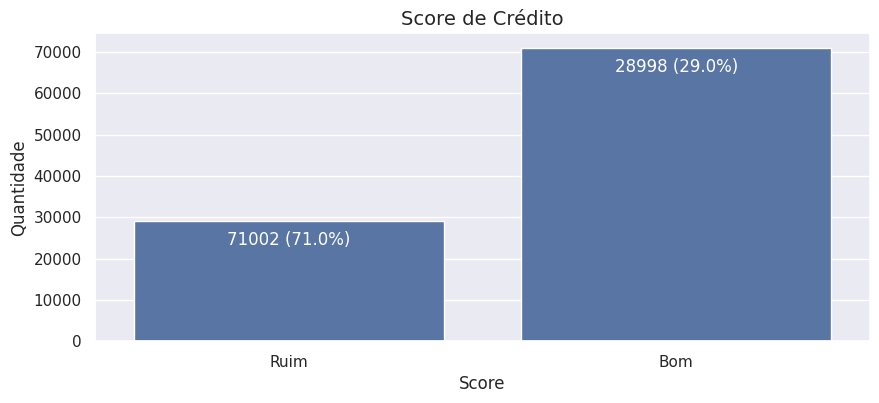

In [ ]:
total = len(df_final['Credit_Score'])
counts = df_final['Credit_Score'].value_counts()

plt.figure(figsize=(10,4))
fig = sns.countplot(data = df_final, x='Credit_Score')
fig.set_title('Score de Crédito', fontsize=14)
fig.set_xlabel('Score', fontsize=12)
fig.set_ylabel('Quantidade', fontsize=12)
labels = [f"{v} ({v/total:.1%})" for v in counts]
fig.bar_label(fig.containers[0], labels=labels, padding=-20, color='white', fontsize=12)
fig.xaxis.set_major_locator(FixedLocator([0, 1]))
fig.set_xticklabels(['Ruim', 'Bom'])
plt.show()

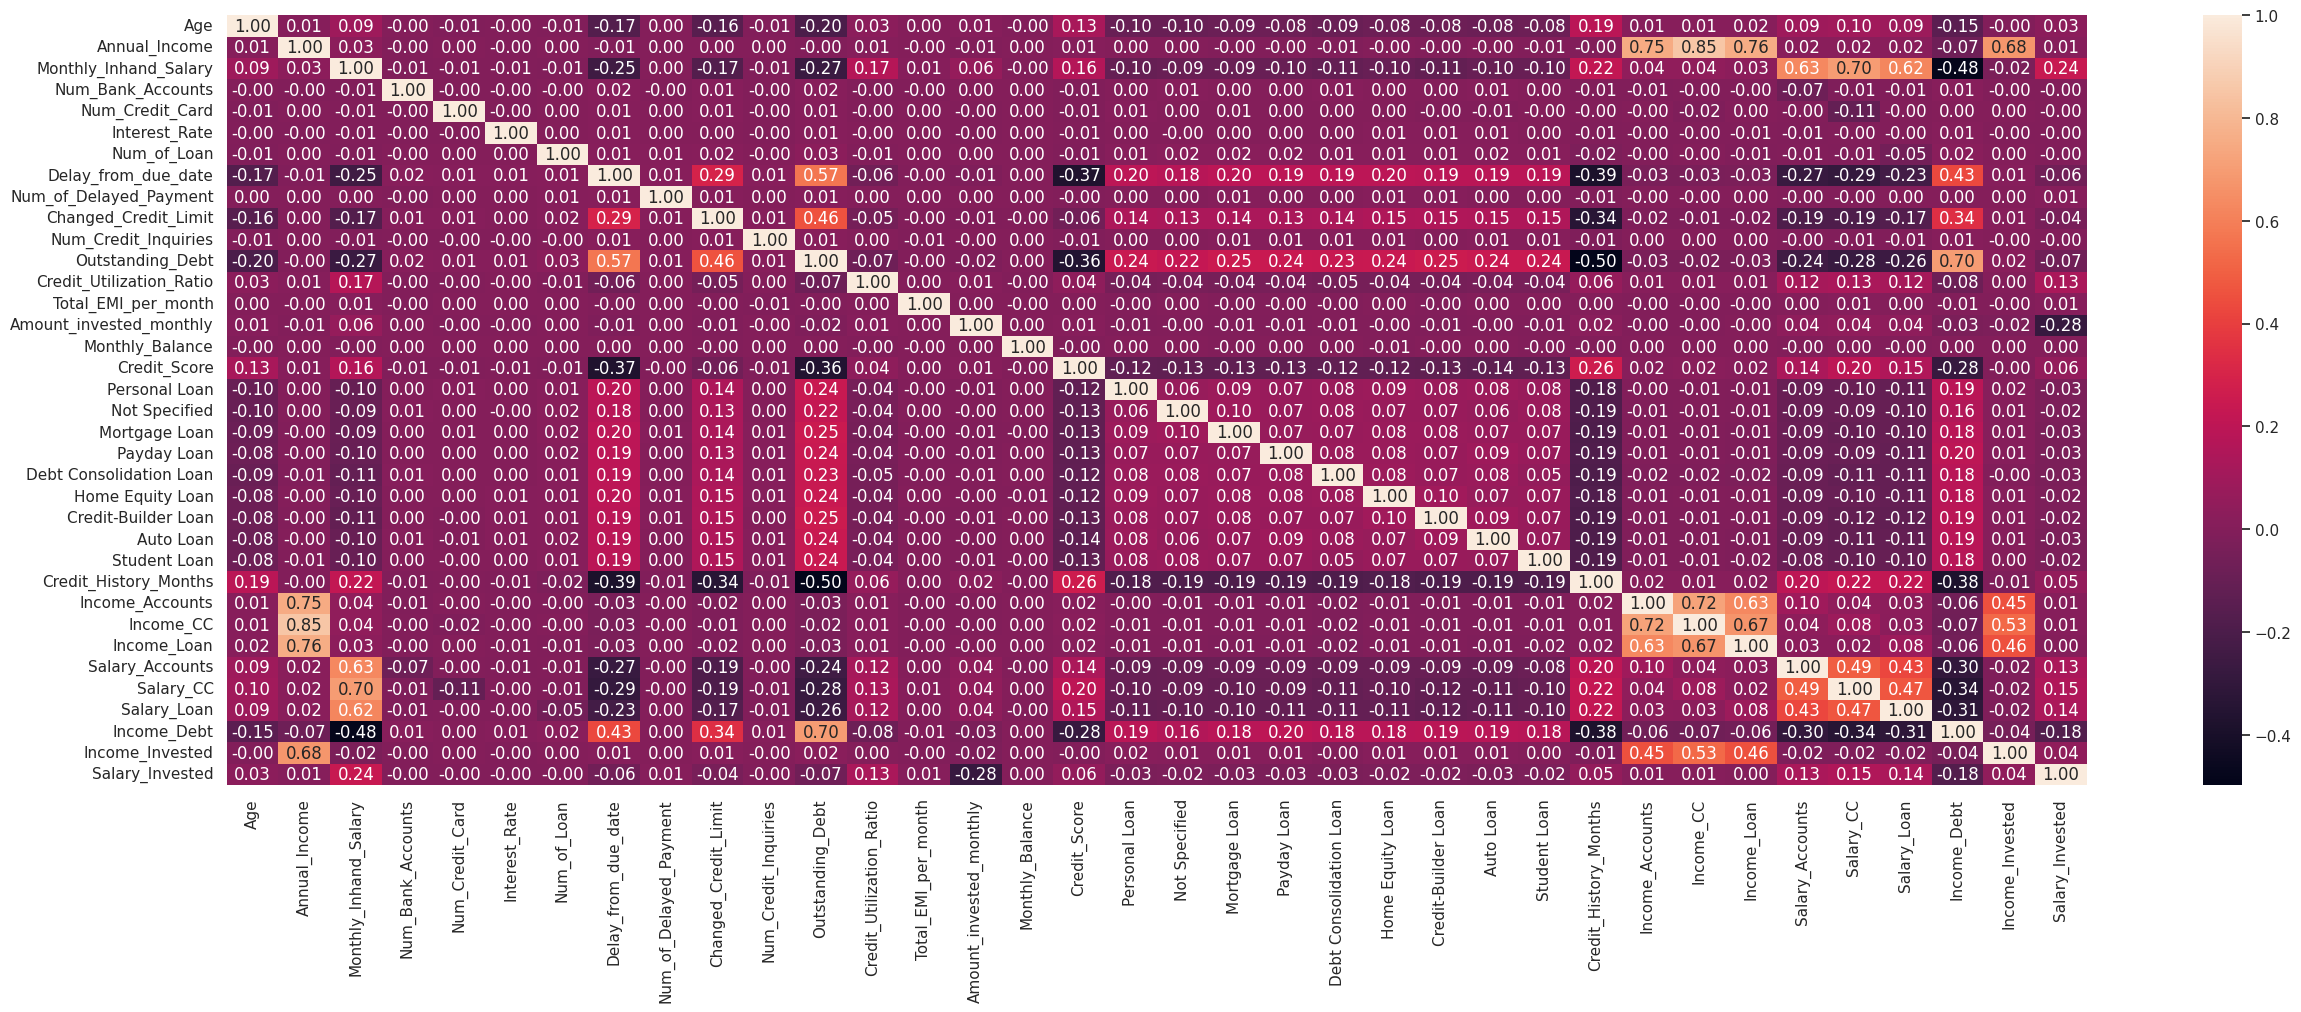

In [ ]:
numeric_columns = df_final.select_dtypes(include='number')
fig = sns.heatmap(data=numeric_columns.corr(method='pearson'), annot=True, fmt='.2f', xticklabels=True, yticklabels=True)
fig.figure.set_size_inches(30, 10)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Modelagem de Dados

In [ ]:
X = df_final.drop('Credit_Score', axis=1)
y = df_final['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70000, 40), (30000, 40), (70000,), (30000,))

In [ ]:
rf = RandomForestClassifier(random_state=42)
gradient_boost = GradientBoostingClassifier(random_state=42)
xgboost = XGBClassifier(random_state=42)

In [ ]:
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')

cat_pipeline = Pipeline([('imputer', cat_imputer), ('encoder', CatBoostEncoder())])
num_pipeline = Pipeline([('imputer', num_imputer)])

cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols = X_train.select_dtypes(exclude=['object']).columns

voting_clf = VotingClassifier(estimators=[('rf', rf), ('gb', gradient_boost), ('xbg', xgboost)],
                              voting='soft')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', voting_clf)])


model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'O...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...))],
                                  voting='soft'))])

In [ ]:
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

conf_matrix = confusion_matrix(y_test, y_pred)


precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC", roc_auc)

Precision: 0.8813207632279308
Recall: 0.9172339326792169
F1-score: 0.8989187945709686
ROC-AUC 0.9157266692124479


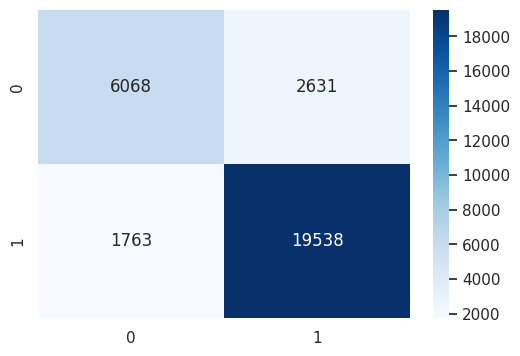

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()